In [1]:
# Loading the libraries we will need

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, callbacks

from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from utils import display



2024-10-04 16:16:35.191688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 16:16:39.929775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 0. Parameters <a name="parameters"></a>

In [2]:
# Model Parameters

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10


## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data downloaded from Tensorflow

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# Preprocess the data

def preprocess(imgs):
    '''
    Normalize and reshape images
    '''
    imgs = imgs.astype('float32') / 255.0
    # (1, 28, 28) --> (1, 32, 32) constant_values is black
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1) # creating a new axis in each image, so now is (1, 32, 32, 1)?
    
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

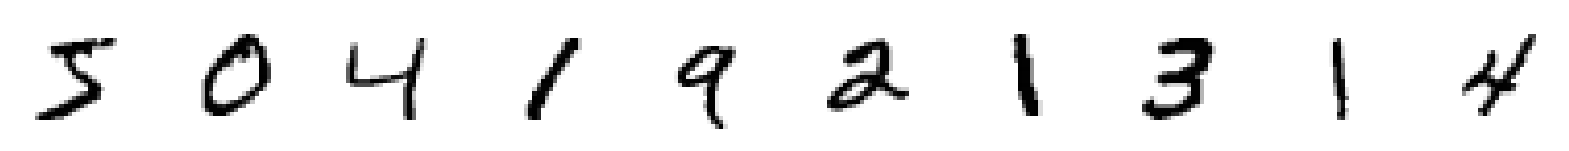

In [5]:
display(x_train)


## 2. Build the autoencoder <a name="build"></a>

In [6]:
# Encoder

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name='encoder_input')

x = layers.Conv2D(32, (3, 3), strides=2, activation ='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()


2024-10-04 16:16:56.249443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:16:58.716763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 16:16:58.720610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

### The Decoder

For the decoder, we are going to mirror the encoder. The counter to Conv2D is the Conv2DTranspose.

|Layer (type)|Output Shape|Param #|
|:----|:----:|----:|
|Input Layer|(None, 2)|0|
|Dense|(None, 2048)|6144|
|Reshape|(None, 4, 4, 128)|0|
|Conv2DTranspose|(None, 8, 8, 128)|147,584|
|Conv2DTranspose|(None, 16, 16, 64)|73,792|
|Conv2DTranspose|(None, 32, 32, 32)|18,464|
|Conv2D|(None, 32, 32, 1)|289|
||||
|Total params||246,273|
|Trainable params||246,273|
|Non-trainable params||0

In [7]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation='sigmoid', padding='same',
                               name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Autoencoder

autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [9]:
# Compile the autoencoder

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(filepath='./checkpoint.keras', 
                            save_weights_only=False, save_freq='epoch',
                            monitor='loss', mode='min', save_best_only=True, verbose=0)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')


In [11]:
# Train the autoencoder
with tf.device('/GPU:0'):
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, 
                validation_data=(x_test, x_test), 
                callbacks=[model_checkpoint_callback, tensorboard_callback])


2024-10-04 16:17:04.055947: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-04 16:17:07.726224: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-04 16:17:08.500009: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-04 16:17:08.879705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1728076644.957974   31872 service.cc:145] XLA service 0x5c42f7f70280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728076644.963576   31872 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-04 16:17:25.225643: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 16:17:25.889675: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1728076661.303499   31872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.2683 - val_loss: 0.1580
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1553 - val_loss: 0.1471
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1470 - val_loss: 0.1432
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1429 - val_loss: 0.1410
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1408 - val_loss: 0.1393
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1389 - val_loss: 0.1384
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1384 - val_loss: 0.1381
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1374 - val_loss: 0.1368
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1368 - val_loss: 0.1368
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.1362 - val_loss: 0.1361


In [12]:
# Save the final models
autoencoder.save('./models/autoencoder.keras')
encoder.save('./models/encoder.keras')
decoder.save('./models/decoder.keras')

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [13]:
# Reconstruct some images

n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]



157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Example real numbered items:


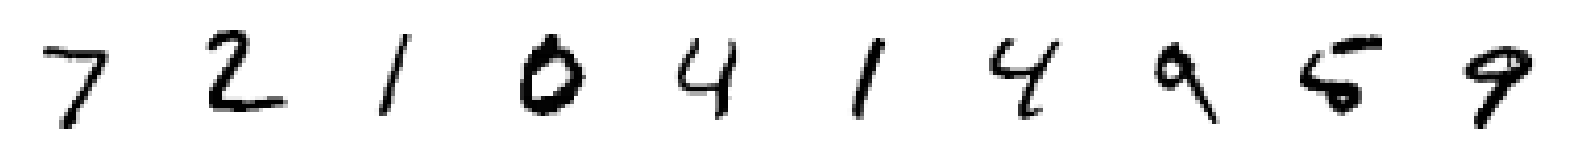

Reconstructions:


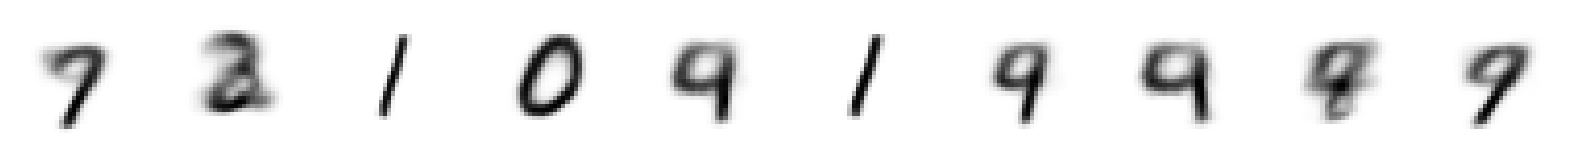

In [14]:
predictions = autoencoder.predict(example_images)
print('Example real numbered items:')
display(example_images)
print('Reconstructions:')
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

Let's see what the latent space looks like after the encoder embeds the input.

In [15]:
# Encode the example images
embeddings = encoder.predict(example_images)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [16]:
# Some examples of the embeddings
print(embeddings[:10])


[[ 1.8936517  -1.6618341 ]
 [-0.59490705 -0.47969273]
 [ 4.531982    0.6323522 ]
 [-1.8894469  -1.0595151 ]
 [ 0.9496095  -3.832474  ]
 [ 3.7217574   0.5881151 ]
 [ 1.4078664  -2.5873468 ]
 [ 0.87429357 -5.7736893 ]
 [ 0.5222515  -1.1624981 ]
 [ 1.3040669  -1.1512352 ]]


Let's look at how the embeddings look in a 2D latent space.

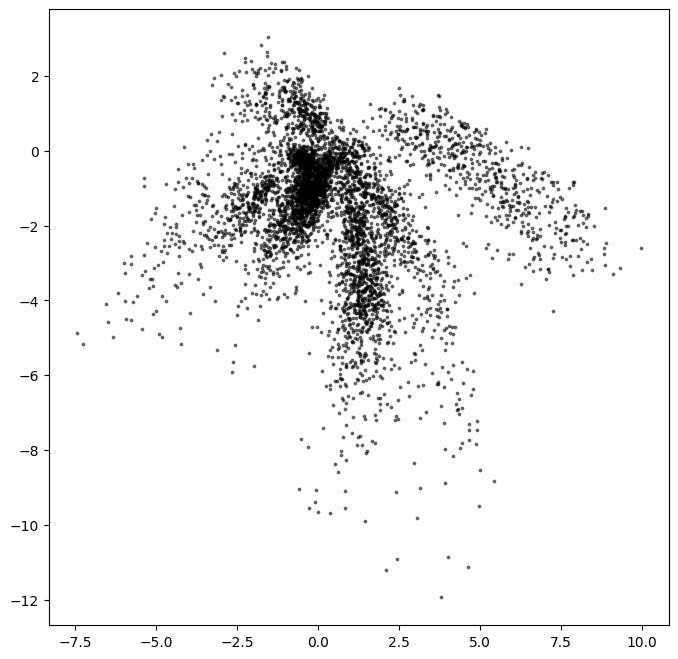

In [17]:
# Show the encoded points in 2D space
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

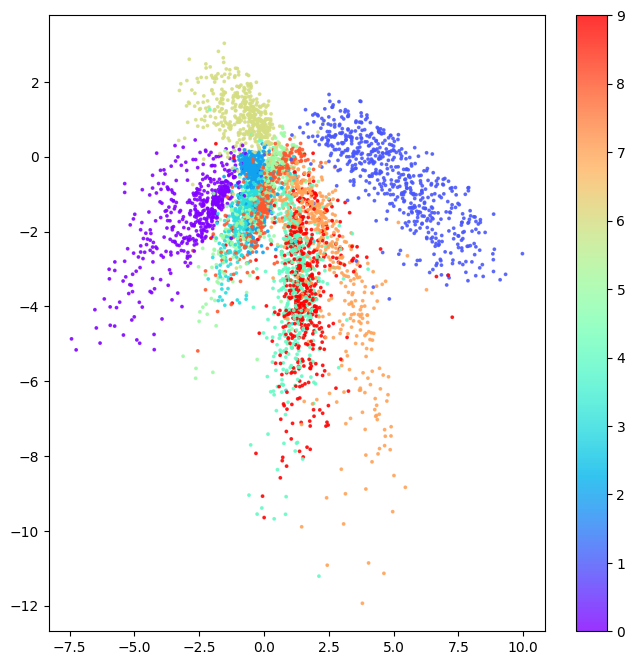

In [18]:
# Color the embeddings by their label (clothing type - see table)

example_labels = y_test[:n_to_predict]
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1],
           cmap='rainbow', c=example_labels, alpha = 0.8, s = 3)
plt.colorbar()
plt.show()


## 6. Generate using the decoder <a name="decode"></a>


In [19]:
# Get the range of the existing embeddings

mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width*grid_height, EMBEDDING_DIM))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


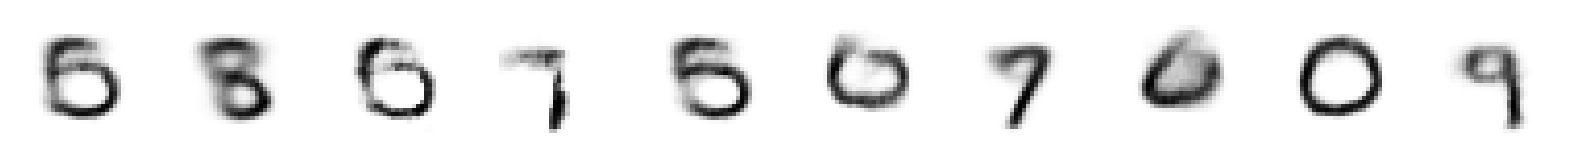

In [20]:
# Decode the sampled points

reconstructions = decoder.predict(sample)
display(reconstructions[:10])

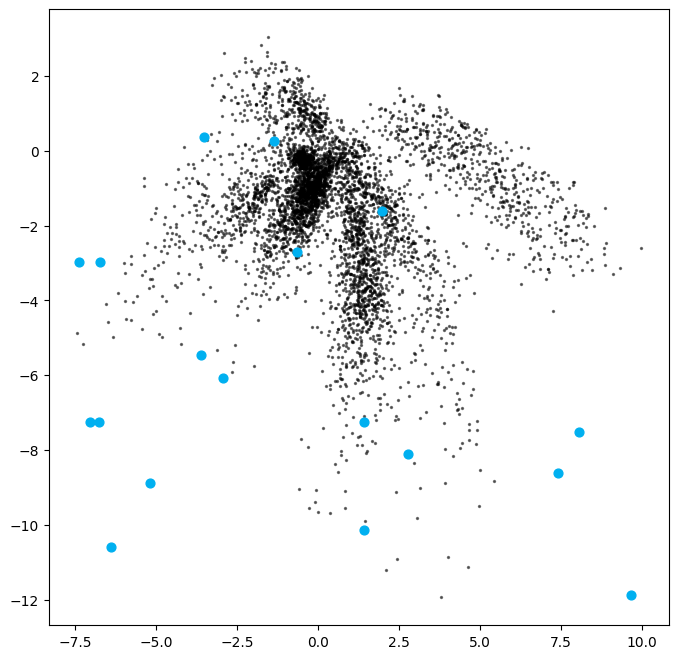

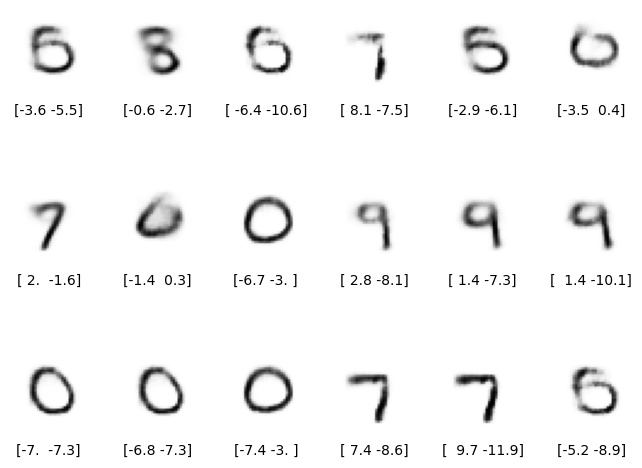

In [21]:
# Draw a plot of...

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(sample[:, 0], sample[:, 1], c='#00B0f0', alpha = 1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap='Greys')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


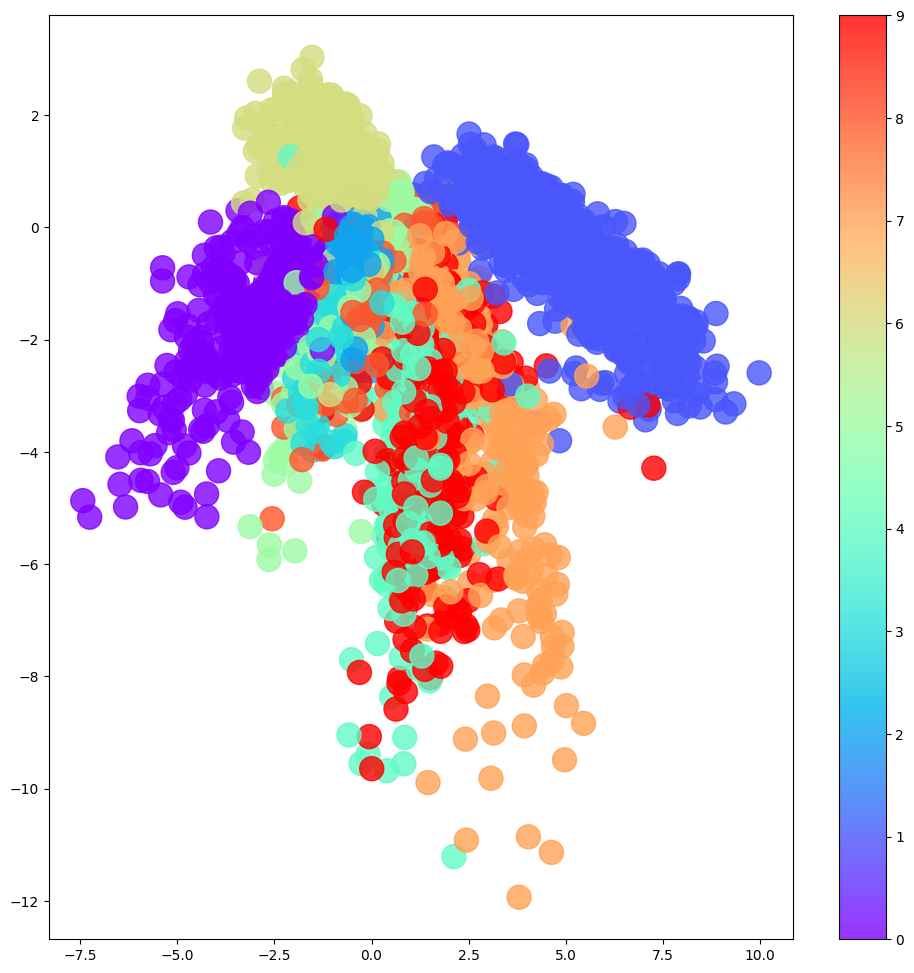

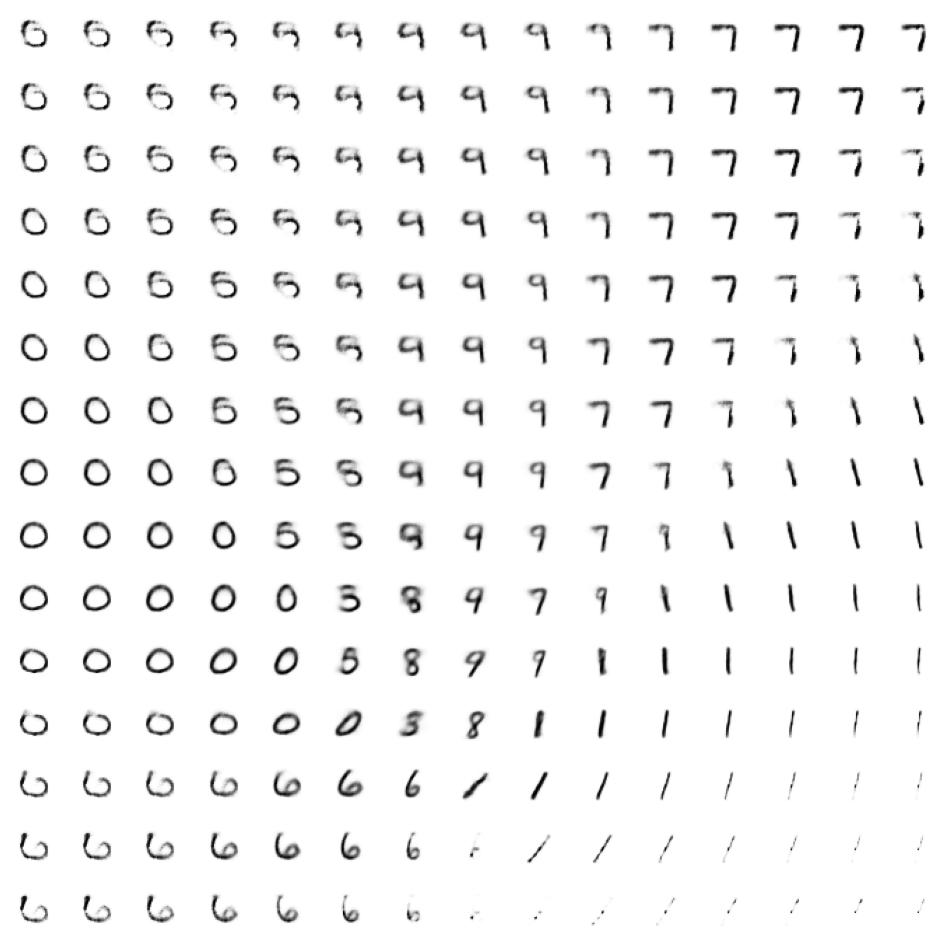

In [22]:
# Color the embeddings by their label (clothing type - see table)

figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1],
           cmap='rainbow', c=example_labels, alpha = 0.8, s = 300)
plt.colorbar()
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(min(embeddings[:, 1]), max(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))
reconstructions = decoder.predict(grid)

plt.show()
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconstructions[i, :, :], cmap='Greys')
    
    
